In [1]:
import torch
import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator

#from google.colab import drive

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import itertools

# Shuo Chen's blade-chest model: модель сабля-рука
Papers

* "Modeling Intransitivity in Matchup and Comparison Data", Shuo Chen and Thorsten Joachims, <br> https://www.cs.cornell.edu/~shuochen/pubs/wsdm16_chen.pdf <br>
* "Predicting Matchups and Preferences in Context", Shuo Chen and Thorsten Joachims, <br> http://csinpi.github.io/pubs/kdd16_chen.pdf

Original code
* https://github.com/csinpi/blade_chest
* https://github.com/csinpi/matchup

#### A metaphorical illustration of the blade-chest model for intransitivity

Player a and player b are in a sword duel. Player a's blade is closer to player b's chest than vice versa, as shown by the two blue dashed lines. This illustrates how player a has a better chance of winning than player b. 

* https://www.researchgate.net/figure/A-metaphorical-illustration-of-the-blade-chest-model-for-intransitivity-Player-a-and_fig1_310825028

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig1/AS:631996141297666@1527691030297/A-metaphorical-illustration-of-the-blade-chest-model-for-intransitivity-Player-a-and.png" alt="Drawing" style="width: 400px;" >


<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig4/AS:631996141277186@1527691030147/Pipeline-of-CONCAT-model.png" alt="Drawing" style="width: 600px;" >

## "Modeling Intransitivity in Matchup and Comparison Data"

"Modeling Intransitivity in Matchup and Comparison Data", Shuo Chen and Thorsten Joachims, <br> https://www.cs.cornell.edu/~shuochen/pubs/wsdm16_chen.pdf 

### 4. EXPERIMENTS
#### 4.1 Synthetic datasets

To demonstrate that our proposed model can capture intransitivity on synthetic datasets, we begin by looking at the classic rockpaper-scissors game. The training dataset is generated as follows:
there are three players, namely rock, paper and scissors. 
We generate 3, 000 games among them, with rock beating scissors 1,000
times, scissors beating paper 1,000 times, and paper beating rock
1,000 times. We trained our blade-chest-dist model without the
bias term, and we set the dimensionality of the vectors to be d = 2.
We then visualize the learned model in the left panel of Figure 2.
Each player is represented by an arrow, with the head being its
blade vector, and the tail being its chest vector. The interlocking
pattern in the visualization is evidence that our model captures the
intransitive rule between the rock, paper and scissors.

There is also an interesting extension of the original rock-paperscissors game in popular culture called 
rock-paper-scissors-lizard-Spock. In addition to the three-way intransitivity between rock,
paper and scissors, new rules for the other two players are added,
and a graphical demonstration of the rules can be found here. 
We generated 1, 000 matches for each matchup, and then do the training and visualization analogous to the classic rock-paper-scissors game. The results are shown in the right panel of Figure 2. Here
we observe the similar interlocking pattern, with each of the 10
matchups correctly demonstrated.

In [2]:
def generate_dataset(units = ['rock', 'paper', 'scissors'], 
                     match = {   ('rock', 'paper')     : 0,
                                  ('rock', 'scissors')  : 1,
                             #     ('rock', 'rock')      : 0.5,
                                 
                                  ('paper', 'scissors') : 0,
                                  ('paper', 'rock', )   : 1,
                             #     ('paper', 'paper')    : 0.5,
                                 
                                  ('scissors', 'rock', )   : 0,
                                  ('scissors', 'paper')    : 1,
                             #     ('scissors', 'scissors') : 0.5
                                },
                     n = 1000, 
                     random_seed = 1543
                    ):
    
    n_units = len(units)
    arr = []

    j = 0
    for i_1, unit_1 in enumerate(units):
        for i_2, unit_2 in enumerate(units):
            
            if unit_1 == unit_2:                   # Исключаем ничьи
                continue
            
            for i in range (n):
                arr.extend( [[ i_1, i_2, match[(unit_1, unit_2)] ]] ) 
                j += 1
          
    np.random.seed(random_seed)
    np.random.shuffle(arr)
       
    return np.array(arr)

In [3]:
def get_team_encoding(X, columns, prefix):
    result = 0
    for col in columns:
        result += pd.get_dummies(X[:, col], prefix = '_'.join([prefix, str(col)]) )
    return result

## Формируем данные train, val, test

Контролируем доли матчей разных видов

In [4]:
data_train = generate_dataset(n = 6000, random_seed = 1)
data_val   = generate_dataset(n = 2000, random_seed = 2)
data_test  = generate_dataset(n = 2000, random_seed = 3)

X_train = data_train[:,:2]
y_train = data_train[:,2:3]

X_val   = data_val[:,:2]
y_val   = data_val[:,2:3]

X_test  = data_test[:,:2]
y_test  = data_test[:,2:3]

y_train.sum(), y_val.sum(), y_test.sum()

(18000, 6000, 6000)

In [5]:
team1_train = get_team_encoding( X_train, columns=[0], prefix='team1' )
team2_train = get_team_encoding( X_train, columns=[1], prefix='team2' )

team1_val   = get_team_encoding( X_val,   columns=[0], prefix='team1' )
team2_val   = get_team_encoding( X_val,   columns=[1], prefix='team2' )

team1_test  = get_team_encoding( X_test,  columns=[0], prefix='team1' )
team2_test  = get_team_encoding( X_test,  columns=[1], prefix='team2' )

In [6]:
# Проверим, какие комбинации в каком количестве представлены
# train
pd.concat([team1_train, team2_train], axis=1
         ).apply(lambda x: '_'.join(list(map(str, x))), 
                 axis=1
                ).value_counts().sort_index(ascending=False)



1_0_0_0_1_0    6000
1_0_0_0_0_1    6000
0_1_0_1_0_0    6000
0_1_0_0_0_1    6000
0_0_1_1_0_0    6000
0_0_1_0_1_0    6000
dtype: int64

In [7]:
# Проверим, какие комбинации в каком количестве представлены
# val
pd.concat([team1_val, team2_val], axis=1
         ).apply(lambda x: '_'.join(list(map(str, x))), 
                 axis=1
                ).value_counts().sort_index(ascending=False)

1_0_0_0_1_0    2000
1_0_0_0_0_1    2000
0_1_0_1_0_0    2000
0_1_0_0_0_1    2000
0_0_1_1_0_0    2000
0_0_1_0_1_0    2000
dtype: int64

* #### Формируем данные и разбиваем их на train, val, test <br> <br> Не используется

In [8]:
# data = generate_dataset(n = 10000)

# X = data[:,:2]
# Y = data[:,2:3]

In [9]:
# team1_encoding = get_team_encoding( X, columns=[0], prefix='team1' )
# team2_encoding = get_team_encoding( X, columns=[1], prefix='team2' )

In [10]:
# (team1_train_test, team1_val, 
#  team2_train_test, team2_val, 
#  y_train_test, y_val) = train_test_split(team1_encoding, 
#                                          team2_encoding, 
#                                          Y, 
#                                          test_size = 0.20,
#                                          shuffle = True, 
#                                          random_state=1543 )

# (team1_train, team1_test, 
#  team2_train, team2_test, 
#  y_train, y_test) = train_test_split(team1_train_test, 
#                                      team2_train_test, 
#                                      y_train_test, 
#                                      test_size = 0.25,
#                                      shuffle = True, 
#                                      random_state=1543 )

# print(team1_train.shape, team1_test.shape, team1_val.shape)
# print(team2_train.shape, team2_test.shape, team2_val.shape)
# print(y_train.shape,      y_test.shape,    y_val.shape)

In [11]:
# X_train = pd.concat([team1_train, team2_train], axis=1)
# X_train.head()

In [12]:
# # Проверим, какие комбинации в каком количестве представлены

# pd.concat([team1_train, team2_train], axis=1
#          ).apply(lambda x: '_'.join(list(map(str, x))), 
#                  axis=1
#                 ).value_counts().sort_index(ascending=False)

## Подготовим данные для обучения

In [13]:
def get_set(team1_train, team2_train, y_train):
    team1_train = torch.cuda.FloatTensor(team1_train.values)
    team2_train = torch.cuda.FloatTensor(team2_train.values)
    y_train     = torch.cuda.FloatTensor(y_train)
    train_set   = TensorDataset(team1_train, team2_train, y_train)
    return train_set

train_set = get_set(team1_train, team2_train, y_train)
val_set   = get_set(team1_val,   team2_val,   y_val  )
test_set  = get_set(team1_test,  team2_test,  y_test )

In [14]:
train_set[0]

(tensor([1., 0., 0.], device='cuda:0'),
 tensor([0., 1., 0.], device='cuda:0'),
 tensor([0.], device='cuda:0'))

In [15]:
# Объединяем данные в батчи

# Обучение
# train_loader -- перемешиваем данные при загрузке, shuffle = True, 
#                 чтобы каждая эпоха училась чуть по-разному
train_loader  = DataLoader(train_set, batch_size = 128, shuffle = True)

# Оценка качества прогноза
train2_loader = DataLoader(train_set, batch_size = 128, shuffle = False)
val_loader    = DataLoader(val_set,   batch_size = 128, shuffle = False)
test_loader   = DataLoader(test_set,  batch_size = 128, shuffle = False)

# Пример прогноза и визуализация
val1_loader   = DataLoader(val_set,   batch_size = 1,   shuffle = False)

## Модель: Shuo Chen's blade-chest inner model


### Модель
* Модель матча   $ M(a,b)$ - разность скалярных произведений <br>  $ M(a,b) = {( \mathbf{a}_{blade} \cdot \mathbf{b}_{chest} )} - {( \mathbf{b}_{blade} \cdot \mathbf{a}_{chest} )} $ <br><br>
* Embedding без bias: nn.Linear(num_units, num_embeddings, bias=False)

<br><br>
* С контрольной печатью в forward

### Оптимизация
* с $L_2$ регуляризацией коэффициентов матриц $blade\_emb$ и $chest\_emb$
* с $L_2$ регуляризацией разности $blade\_emb - chest\_emb$

### Визуалиазация
* с контрольной печатью и картинкой

In [16]:
# Параметры модели

num_u   = 3        # 3 объекта: камень, ножницы, бумага      # team1_train_test.shape[1]
num_emb = 2        # 2-мерная модель

In [17]:
def batch_dot(x, y):
    return (x * y).sum(dim=1, keepdims=True)

class BladeChest(nn.Module):
    def __init__(self, num_units=num_u, num_embeddings=num_emb, verbose = False):
        super(BladeChest, self).__init__()
        self.blade_emb = nn.Linear(num_units, num_embeddings, bias=False)
        self.chest_emb = nn.Linear(num_units, num_embeddings, bias=False)

    def forward(self, batch, verbose = False):
        team1, team2 = batch
        team1_blade = self.blade_emb(team1)
        team2_blade = self.blade_emb(team2)
        team1_chest = self.chest_emb(team1)
        team2_chest = self.chest_emb(team2)

        team1_attack = batch_dot(team1_blade, team2_chest)
        team2_attack = batch_dot(team2_blade, team1_chest)
        
        logits = team1_attack - team2_attack
        
        # -------------------------------------------
        if verbose:
            
            print('------------')
            for param in blade_chest_model.named_parameters():
                print(param)
                print()
    
            print('------------')
            print('team1       ', team1)
            print('team1_blade ', team1_blade)
            print('team1_chest ', team1_chest)
            print(              )
            print('team2       ', team2)
            print('team2_blade ', team2_blade)
            print('team2_chest ', team2_chest)
            print(              )
            print('team1_attack', team1_attack)
            print('team2_attack', team2_attack)
            print(              )
            print('logits      ', logits)
            print('prob        ', torch.sigmoid(logits))
        # -------------------------------------------
        
        return logits
    
    
#     def forward_print(self, batch):
#         team1, team2 = batch
#         team1_blade = self.blade_emb(team1)
#         team2_blade = self.blade_emb(team2)
#         team1_chest = self.chest_emb(team1)
#         team2_chest = self.chest_emb(team2)

#         team1_attack = batch_dot(team1_blade, team2_chest)
#         team2_attack = batch_dot(team2_blade, team1_chest)
        
#         logits = team1_attack - team2_attack
        
#         print('------------')
#         for param in blade_chest_model.named_parameters():
#             print(param)
#             print()
    
#         print('------------')
#         print('team1       ', team1)
#         print('team1_blade ', team1_blade)
#         print('team1_chest ', team1_chest)
#         print(              )
#         print('team2       ', team2)
#         print('team2_blade ', team2_blade)
#         print('team2_chest ', team2_chest)
#         print(              )
#         print('team1_attack', team1_attack)
#         print('team2_attack', team2_attack)
#         print(              )
#         print('logits      ', logits)
#         print('prob        ', torch.sigmoid(logits))
        
#         return logits


In [18]:
# def batch_dot(x, y):
#     return (x * y).sum(dim=1, keepdims=True)

# class BladeChest(nn.Module):
#     def __init__(self, num_units=num_u, num_embeddings=num_emb):
#         super(BladeChest, self).__init__()
#         self.blade_emb = nn.Linear(num_units, num_embeddings)
#         self.chest_emb = nn.Linear(num_units, num_embeddings)

#     def forward(self, batch, verbose):
#         team1, team2 = batch
#         team1_blade = self.blade_emb(team1)
#         team2_blade = self.blade_emb(team2)
#         team1_chest = self.chest_emb(team1)
#         team2_chest = self.chest_emb(team2)

#         team1_attack = batch_dot(team1_blade, team2_chest)
#         team2_attack = batch_dot(team2_blade, team1_chest)
        
#         logits = team1_attack - team2_attack
#         return logits

In [19]:
# Объявляем модель
blade_chest_model = BladeChest( num_units      = num_u, 
                                num_embeddings = num_emb
                              ).cuda()

# Функция потерь
crossentropy = nn.BCEWithLogitsLoss()

# Оптимизатор
optimizer = torch.optim.Adam(blade_chest_model.parameters(), 
                             lr=1e-4)

In [20]:
blade_emb = next( blade_chest_model.blade_emb.parameters())
chest_emb = next( blade_chest_model.chest_emb.parameters())
#
print(blade_emb)
print(chest_emb)


print(blade_emb.detach().cpu().numpy())
print(chest_emb.detach().cpu().numpy())

torch.norm(blade_emb - chest_emb)

Parameter containing:
tensor([[-0.1785,  0.2558,  0.1430],
        [ 0.5690, -0.5564,  0.2387]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.2316,  0.1022,  0.3206],
        [ 0.2713, -0.1109, -0.0910]], device='cuda:0', requires_grad=True)
[[-0.17854309  0.25575334  0.14296636]
 [ 0.56903255 -0.5563687   0.23872653]]
[[-0.23155394  0.10217609  0.3206492 ]
 [ 0.2713158  -0.11086145 -0.09100791]]


tensor(0.6736, device='cuda:0', grad_fn=<CopyBackwards>)

In [21]:
def run_epoch(model, 
              optimizer = optimizer, 
              training=True, 
              L2 = 0,                 # Регуляризация L2 для коэффициентов модели
              L2_diff = 0,            # Регуляризация L2 для коэффициентов разности: blade - chest
             ):
    '''
    Оптимизация модели для одной эпохи
    + Добавлена регуляризация: L2, L2_diff
    + Добавлена контрольная печать: verbose
    '''
    
    loss_values = []
    
    model.train(training)
    
    dataloader = train_loader if training else val_loader
    
    for i, (batch_team1, batch_team2, batch_y) in tqdm(enumerate(dataloader)):
        out = model((batch_team1, batch_team2), verbose=False)
        optimizer.zero_grad()
        
        #print(out.dtype, batch_y.dtype)
        batch_loss = crossentropy(out, batch_y)

        # Регуляризация весов, но не свободных членов.
        # Adapted from: https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        if L2 > 0:
            L2_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    L2_reg = L2_reg + torch.norm(param, 2)
            batch_loss = batch_loss + L2 * L2_reg
        
        if L2_diff > 0:
            L2_diff_reg = torch.tensor(0., requires_grad=True)
            blade_emb = next( blade_chest_model.blade_emb.parameters())
            chest_emb = next( blade_chest_model.chest_emb.parameters())
            L2_diff_reg = torch.norm(blade_emb - chest_emb, 2)
            batch_loss = batch_loss + L2_diff * L2_diff_reg

        if training:
            batch_loss.backward()
            optimizer.step()
            
        loss_values.append(batch_loss.item())
        
    return loss_values

In [22]:
def get_prediction(dataloader, model, verbose=False):
    '''
    Прогноз для данных
    + Добавлена контрольная печать: verbose
    '''
    result = []
       
    for i, (batch_team1, batch_team2, y) in enumerate(dataloader):  # dataloader yields (batch_team1, batch_team2, y)
        out = torch.sigmoid( model.forward((batch_team1, batch_team2), verbose = verbose) )
        out = list( out.detach().cpu()[:,0].numpy() )
        result.extend(out)
        
    return result

In [23]:
# Обучаем модель

train_batch_loss = []

train_epoch_loss = []
test_epoch_loss  = []
val_epoch_loss   = []

for epoch in range(100):
    train_batch_loss = train_batch_loss + run_epoch(blade_chest_model, optimizer = optimizer,
                                                    L2 = 1e-3, 
                                                    L2_diff = 0)
    
    train_prediction = get_prediction(train2_loader, blade_chest_model, verbose=False)    # train2_loader - без shuffle
    val_prediction   = get_prediction(val_loader,    blade_chest_model, verbose=False)
    test_prediction  = get_prediction(test_loader,   blade_chest_model, verbose=False)  
    
    train_epoch_loss.append( log_loss(y_train, train_prediction) )
    val_epoch_loss.append(   log_loss(y_val,   val_prediction)   )
    test_epoch_loss.append(  log_loss(y_test,  test_prediction)  )


282it [00:01, 203.69it/s]
282it [00:01, 203.71it/s]
282it [00:01, 215.07it/s]
282it [00:01, 226.75it/s]
282it [00:01, 196.02it/s]
282it [00:01, 230.82it/s]
282it [00:01, 248.41it/s]
282it [00:01, 207.16it/s]
282it [00:01, 243.31it/s]
282it [00:01, 273.07it/s]
282it [00:00, 283.17it/s]
282it [00:01, 261.17it/s]
282it [00:01, 271.85it/s]
282it [00:01, 200.33it/s]
282it [00:01, 226.83it/s]
282it [00:01, 264.80it/s]
282it [00:01, 202.00it/s]
282it [00:01, 245.06it/s]
282it [00:01, 201.83it/s]
282it [00:01, 199.59it/s]
282it [00:01, 202.33it/s]
282it [00:01, 223.11it/s]
282it [00:01, 279.43it/s]
282it [00:01, 274.08it/s]
282it [00:01, 207.86it/s]
282it [00:01, 247.41it/s]
282it [00:01, 275.26it/s]
282it [00:01, 253.24it/s]
282it [00:00, 354.09it/s]
282it [00:00, 286.85it/s]
282it [00:01, 264.94it/s]
282it [00:01, 231.85it/s]
282it [00:01, 225.24it/s]
282it [00:01, 272.22it/s]
282it [00:01, 232.79it/s]
282it [00:01, 219.28it/s]
282it [00:01, 203.49it/s]
282it [00:01, 212.22it/s]
282it [00:01

In [24]:
test_prediction   = get_prediction(test_loader,    blade_chest_model)

test_loss = log_loss(y_test, test_prediction)
print('Blade-chest model test_loss', test_loss)

Blade-chest model test_loss 0.0004803201785155882


In [25]:
val_prediction   = get_prediction(val_loader,    blade_chest_model)
val_prediction

val_loss = log_loss(y_val, val_prediction)
print('Blade-chest model val_loss ', val_loss)

Blade-chest model val_loss  0.0004803201785155882


Text(0, 0.5, 'loss')

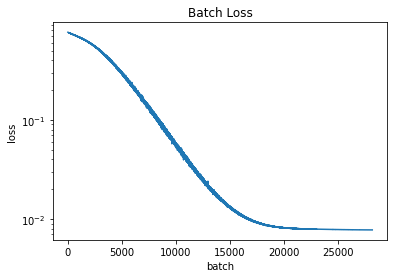

In [26]:
plt.plot(train_batch_loss)
plt.yscale('log')
plt.title('Batch Loss')
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

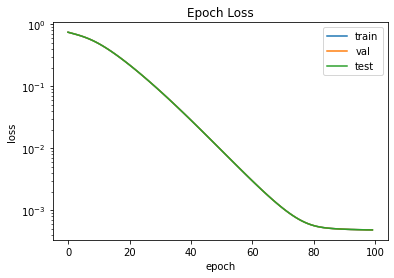

In [27]:
plt.plot(train_epoch_loss, label = 'train')
plt.plot(val_epoch_loss,   label = 'val'  )
plt.plot(test_epoch_loss,  label = 'test' )
plt.legend()
plt.yscale('log')
plt.title('Epoch Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

### Визуалиазция прогноза

In [28]:
# С помощью метода forward

for i, (batch_team1, batch_team2, batch_y) in enumerate(val1_loader):
    
    print('batch_team1', batch_team1)
    print('batch_team2', batch_team2)
    print('batch_y    ', batch_y)
    
    prediction = blade_chest_model((batch_team1, batch_team2), verbose=True)
    
    print('------------')
    print('prediction', prediction)
    break

batch_team1 tensor([[0., 1., 0.]], device='cuda:0')
batch_team2 tensor([[0., 0., 1.]], device='cuda:0')
batch_y     tensor([[0.]], device='cuda:0')
------------
('blade_emb.weight', Parameter containing:
tensor([[-1.6647, -0.3031,  1.9480],
        [ 2.1424, -1.3454, -1.0047]], device='cuda:0', requires_grad=True))

('chest_emb.weight', Parameter containing:
tensor([[-1.3535,  1.9255, -0.8302],
        [-0.1810, -1.7707,  1.7647]], device='cuda:0', requires_grad=True))

------------
team1        tensor([[0., 1., 0.]], device='cuda:0')
team1_blade  tensor([[-0.3031, -1.3454]], device='cuda:0', grad_fn=<MmBackward>)
team1_chest  tensor([[ 1.9255, -1.7707]], device='cuda:0', grad_fn=<MmBackward>)

team2        tensor([[0., 0., 1.]], device='cuda:0')
team2_blade  tensor([[ 1.9480, -1.0047]], device='cuda:0', grad_fn=<MmBackward>)
team2_chest  tensor([[-0.8302,  1.7647]], device='cuda:0', grad_fn=<MmBackward>)

team1_attack tensor([[-2.1227]], device='cuda:0', grad_fn=<SumBackward1>)
team2_

In [29]:
team1_010 = np.array([[0., 1., 0.]])

blade_emb = np.array([[ 2.0636, -2.1808, -0.3340],
                      [ 1.7583, -0.2254, -2.2194]])

team1_010.dot(blade_emb.T)

array([[-2.1808, -0.2254]])

In [30]:
# # С помощью метода forward_print

# for i, (batch_team1, batch_team2, batch_y) in enumerate(val1_loader):
    
#     print('batch_team1', batch_team1)
#     print('batch_team2', batch_team2)
#     print('batch_y    ', batch_y)
#     prediction = blade_chest_model.forward_print((batch_team1, batch_team2))
#     print('prediction', prediction)
#     break

### Визуалиазция коэффициентов модели

#### Напечатаем коэффциенты

In [31]:
for param in blade_chest_model.named_parameters():
    print(param)
    print('---------------------------')

('blade_emb.weight', Parameter containing:
tensor([[-1.6647, -0.3031,  1.9480],
        [ 2.1424, -1.3454, -1.0047]], device='cuda:0', requires_grad=True))
---------------------------
('chest_emb.weight', Parameter containing:
tensor([[-1.3535,  1.9255, -0.8302],
        [-0.1810, -1.7707,  1.7647]], device='cuda:0', requires_grad=True))
---------------------------


In [32]:
for param in blade_chest_model.parameters():
    print(param)
    print('---------------------------')

Parameter containing:
tensor([[-1.6647, -0.3031,  1.9480],
        [ 2.1424, -1.3454, -1.0047]], device='cuda:0', requires_grad=True)
---------------------------
Parameter containing:
tensor([[-1.3535,  1.9255, -0.8302],
        [-0.1810, -1.7707,  1.7647]], device='cuda:0', requires_grad=True)
---------------------------


In [33]:
blade_chest_model.blade_emb, blade_chest_model.chest_emb 

(Linear(in_features=3, out_features=2, bias=False),
 Linear(in_features=3, out_features=2, bias=False))

In [34]:
blade_chest_model.blade_emb.weight

Parameter containing:
tensor([[-1.6647, -0.3031,  1.9480],
        [ 2.1424, -1.3454, -1.0047]], device='cuda:0', requires_grad=True)

#### Визуалиазция коэффициентов

In [35]:
blade, chest = (
    blade_chest_model.blade_emb.weight.data.detach().cpu().numpy(),
    blade_chest_model.chest_emb.weight.data.detach().cpu().numpy()
)

print(blade)
print(chest)

[[-1.6646628  -0.30306903  1.9480432 ]
 [ 2.1424332  -1.3454243  -1.0046706 ]]
[[-1.3535407   1.9254565  -0.83022505]
 [-0.18098368 -1.7706753   1.7647011 ]]


0 (-1.3535407, -0.18098368, -0.31112218, 2.323417)
1 (1.9254565, -1.7706753, -2.2285256, 0.425251)
2 (-0.83022505, 1.7647011, 2.7782683, -2.7693717)


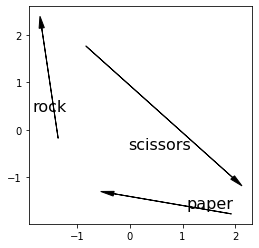

In [36]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

offset = [[0, -0.5],      # rock
          [0.7, 0],      # paper
          [0.0, -0.7],    # scissors
         ]

for i, unit in enumerate(['rock', 'paper', 'scissors']):
    unit_blade = blade[:,i]
    unit_chest = chest[:,i]
    x, y   = unit_chest
    dx, dy = unit_blade - unit_chest
    ox, oy = offset[i]
    
    print(i, (x, y, dx, dy))
    ax.arrow(x,  y, 
             dx, dy, 
             head_width=0.1, head_length=0.25, fc='black', ec='black')
    
    ax.text(x + dx/2 + ox, y + dy/2 + oy, 
            s = unit, 
            size=16, ha='center', va='center', color='black')
    
plt.show()    
#x, y

В статьях Shuo Chen получилась более регулярная картина. <br> 
Вероятно, он использовал регуляризацию или контролировал начальные коэффициенты

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig9/AS:631996137086978@1527691029945/The-visualization-of-the-blade-chest-dist-model-trained-on-a-synthetic.png" alt="Drawing" style="width: 400px;" align="left" >



## Обсуждение 

* Сосчитать прогноз вручную по коэффициентам модели
* Удадить свободные члены из модели
* Модификации метрики близости
    * Косинус углов вместо скалярного произведения
    * Покомпонетное превышение
* Модификации модели
    * Cинергия юнитов


### Технические замечания

#### Регуляризация: L1, L2, своя функция регуляризации

https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch


<code>L1_reg = torch.tensor(0., requires_grad=True)
for name, param in model.named_parameters():
    if 'weight' in name:                                 # Пример регуляризации для весов, но не bias
        L1_reg = L1_reg + torch.norm(param, 1)
total_loss = total_loss + 10e-4 * L1_reg</code>

# Остановка рассчёта

In [37]:
#1/0

## Оптимизация модели: Shuo Chen's blade-chest distance model

* Модель исхода матча: <br> $M(a,b) = {\| \mathbf{b}_{blade} - \mathbf{a}_{chest} \|}^{2} - {\| \mathbf{a}_{blade} - \mathbf{b}_{chest} \|}^{2} $ <br><br>
* Embedding без bias: nn.Linear(num_units, num_embeddings, bias=False)


In [38]:
class BladeChestDistance(nn.Module):
    def __init__(self, num_units=num_u, num_embeddings=num_emb):
        super(BladeChestDistance, self).__init__()
        self.blade_emb = nn.Linear(num_units, num_embeddings, bias=False)
        self.chest_emb = nn.Linear(num_units, num_embeddings, bias=False)

    def forward(self, batch):
        team1, team2 = batch
        team1_blade = self.blade_emb(team1)
        team2_blade = self.blade_emb(team2)
        team1_chest = self.chest_emb(team1)
        team2_chest = self.chest_emb(team2)
        
        blade1_chest2 = team1_blade - team2_chest
        blade2_chest1 = team2_blade - team1_chest

        team1_attack = - batch_dot(blade1_chest2, blade1_chest2)
        team2_attack = - batch_dot(blade2_chest1, blade2_chest1)
        
        logits = team1_attack - team2_attack
        return logits

In [39]:
# Объявляем модель
blade_chest_distance_model = BladeChestDistance( num_units      = num_u, 
                                                 num_embeddings = num_emb
                                               ).cuda()

In [40]:
# Функция потерь
crossentropy = nn.BCEWithLogitsLoss()  

In [41]:
# Оптимизатор
optimizer = torch.optim.Adam(blade_chest_distance_model.parameters(), 
                             lr=1e-4)

In [48]:
def get_prediction(dataloader, model, verbose=False):
    '''
    Прогноз для данных
    - НЕ добавлена контрольная печать: verbose
    '''
    result = []
       
    for i, (batch_team1, batch_team2, y) in enumerate(dataloader):  # dataloader yields (batch_team1, batch_team2, y)
        out = torch.sigmoid( model.forward((batch_team1, batch_team2)
                                           #, verbose = verbose
                                          ) 
                           )
        out = list( out.detach().cpu()[:,0].numpy() )
        result.extend(out)
        
    return result

In [49]:
def run_epoch(model, 
              optimizer = optimizer, 
              training=True, 
              L2 = 0,                 # Регуляризация L2 для коэффициентов модели
              L2_diff = 0,            # Регуляризация L2 для коэффициентов разности: blade - chest
             ):
    '''
    Оптимизация модели для одной эпохи
    + Добавлена регуляризация: L2, L2_diff
    - НЕ добавлена контрольная печать: verbose
    '''
    
    loss_values = []
    
    model.train(training)
    
    dataloader = train_loader if training else val_loader
    
    for i, (batch_team1, batch_team2, batch_y) in tqdm(enumerate(dataloader)):
        out = model((batch_team1, batch_team2) 
                    #, verbose=False
                   )
        optimizer.zero_grad()
        
        #print(out.dtype, batch_y.dtype)
        batch_loss = crossentropy(out, batch_y)

        # Регуляризация весов, но не свободных членов.
        # Adapted from: https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        if L2 > 0:
            L2_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    L2_reg = L2_reg + torch.norm(param, 2)
            batch_loss = batch_loss + L2 * L2_reg
        
        if L2_diff > 0:
            L2_diff_reg = torch.tensor(0., requires_grad=True)
            blade_emb = next( blade_chest_model.blade_emb.parameters())
            chest_emb = next( blade_chest_model.chest_emb.parameters())
            L2_diff_reg = torch.norm(blade_emb - chest_emb, 2)
            batch_loss = batch_loss + L2_diff * L2_diff_reg

        if training:
            batch_loss.backward()
            optimizer.step()
            
        loss_values.append(batch_loss.item())
        
    return loss_values

In [50]:
# Обучаем модель

train_batch_loss = []

train_epoch_loss = []
test_epoch_loss  = []
val_epoch_loss   = []

for epoch in range(64):
    train_batch_loss = train_batch_loss + run_epoch(blade_chest_distance_model, optimizer = optimizer)
    
    train_prediction = get_prediction(train2_loader, blade_chest_distance_model)    # train2_loader - без shuffle
    val_prediction   = get_prediction(val_loader,    blade_chest_distance_model)
    test_prediction  = get_prediction(test_loader,   blade_chest_distance_model)  
    
    train_epoch_loss.append( log_loss(y_train, train_prediction) )
    val_epoch_loss.append(   log_loss(y_val,   val_prediction)   )
    test_epoch_loss.append(  log_loss(y_test,  test_prediction)  )


282it [00:00, 318.76it/s]
282it [00:00, 350.82it/s]
282it [00:00, 359.18it/s]
282it [00:00, 356.02it/s]
282it [00:00, 357.15it/s]
282it [00:00, 350.84it/s]
282it [00:00, 355.68it/s]
282it [00:00, 342.07it/s]
282it [00:00, 359.84it/s]
282it [00:00, 360.70it/s]
282it [00:00, 355.99it/s]
282it [00:00, 354.54it/s]
282it [00:00, 358.90it/s]
282it [00:00, 354.13it/s]
282it [00:00, 356.16it/s]
282it [00:00, 357.96it/s]
282it [00:00, 350.65it/s]
282it [00:00, 359.66it/s]
282it [00:00, 343.50it/s]
282it [00:00, 349.46it/s]
282it [00:00, 354.60it/s]
282it [00:00, 353.46it/s]
282it [00:00, 339.98it/s]
282it [00:00, 349.60it/s]
282it [00:00, 350.34it/s]
282it [00:00, 358.05it/s]
282it [00:00, 372.79it/s]
282it [00:00, 357.94it/s]
282it [00:00, 354.41it/s]
282it [00:00, 356.85it/s]
282it [00:00, 359.40it/s]
282it [00:00, 340.64it/s]
282it [00:00, 353.55it/s]
282it [00:00, 354.24it/s]
282it [00:00, 343.81it/s]
282it [00:00, 358.15it/s]
282it [00:00, 354.40it/s]
282it [00:00, 355.37it/s]
282it [00:00

In [51]:
val_prediction   = get_prediction(val_loader,    blade_chest_distance_model)
val_prediction

val_loss = log_loss(y_val, val_prediction)
print('Blade-chest model', val_loss)

Blade-chest model 0.00027065322986648727


Text(0, 0.5, 'loss')

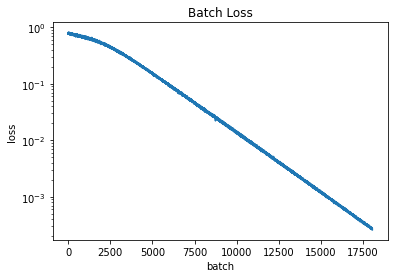

In [52]:
plt.plot(train_batch_loss)
plt.yscale('log')
plt.title('Batch Loss')
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

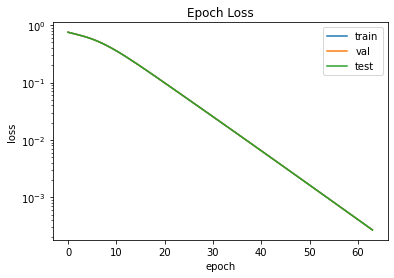

In [53]:
plt.plot(train_epoch_loss, label = 'train')
plt.plot(val_epoch_loss,   label = 'val'  )
plt.plot(test_epoch_loss,  label = 'test' )
plt.legend()
plt.yscale('log')
plt.title('Epoch Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [54]:
blade_chest_distance_model.blade_emb, blade_chest_distance_model.chest_emb 

(Linear(in_features=3, out_features=2, bias=False),
 Linear(in_features=3, out_features=2, bias=False))

In [55]:
blade, chest = (
    blade_chest_distance_model.blade_emb.weight.data.detach().cpu().numpy(),
    blade_chest_distance_model.chest_emb.weight.data.detach().cpu().numpy()
)

print(blade)
print(chest)

[[-1.4407448   0.32605186  1.5851496 ]
 [-0.32853624 -1.5541011   1.1940191 ]]
[[-0.5842249  1.2907299 -1.1656994]
 [-1.1141822  0.9120718  0.9815845]]


0 (-0.5842249, -1.1141822, -0.8565199, 0.78564596)
1 (1.2907299, 0.9120718, -0.96467805, -2.466173)
2 (-1.1656994, 0.9815845, 2.750849, 0.21243459)


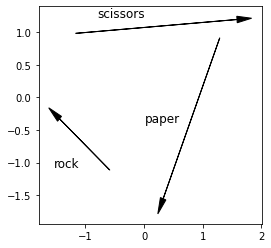

In [56]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

offset = [[-0.3, -0.3],  # rock
          [-0.5, 0],      # paper
          [-0.6, 0.2],      # scissors
         ]

for i, unit in enumerate(['rock', 'paper', 'scissors']):
    unit_blade = blade[:,i]
    unit_chest = chest[:,i]
    x, y   = unit_chest
    dx, dy = unit_blade - unit_chest
    ox, oy = offset[i]
    
    print(i, (x, y, dx, dy))
    ax.arrow(x,  y, 
             dx, dy, 
             head_width=0.1, head_length=0.25, fc='black', ec='black')
    
    ax.text(x + dx/2 + ox, y + dy/2 + oy, 
            s = unit, 
            size=12, ha='center', va='center', color='black')
    
plt.show()    
#x, y

Ожидал, что получится, как в статье

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig9/AS:631996137086978@1527691029945/The-visualization-of-the-blade-chest-dist-model-trained-on-a-synthetic.png" alt="Drawing" style="width: 400px;" align="left" >



# LightGBM

## Как НЕ получить результат

* Из-за особенностей данных, разбиение по любому отдельному признаку не приводит к улучшению качества прогноза.
* Из-за небольшого размера данных, дерево не рзбивает их на группы.

In [57]:
data_train_lgb = np.concatenate([team1_train, team2_train], axis=1)
data_val_lgb   = np.concatenate([team1_val,   team2_val],   axis=1)
data_test_lgb  = np.concatenate([team1_test,  team2_test],  axis=1)

In [58]:
data_train_lgb[:4]

array([[1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0]], dtype=uint8)

In [60]:
lgb = LGBMClassifier(
    n_jobs=10,
    max_depth=3,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt',
#    min_data=1,
#    min_hess=0
)

start = time.time()
lgb.fit(data_train_lgb, y_train.ravel())
lgb_elapse = time.time() - start
print('elapse:, ', lgb_elapse)

elapse:,  0.057291507720947266


In [61]:
y_pred_val = lgb.predict_proba(data_val_lgb)[:, 1]
lgb_auc_val = roc_auc_score(y_val, y_pred_val)
print('auc score val: ', lgb_auc_val)


y_pred_test = lgb.predict_proba(data_test_lgb)[:, 1]
lgb_auc_test = roc_auc_score(y_test, y_pred_test)
print('auc score test:', lgb_auc_test)

auc score val:  0.5
auc score test: 0.5


## Как получить результат

Из-за особенностей данных, разбиение по любому отдельному признаку не приводит к улучшению качества прогноза.

А разбиение сразу по паре признаков позволяет получить достоверные предсказания.

Поэтому из пар признаков создаём комбинированные признаки-пары. Их и будем использовать

In [62]:
def get_pairs_arr(data_lgb):
    pairs_arr = []
    for arr in data_lgb:
        res = int("".join(str(x) for x in list(arr)), 2)
        pairs_arr.extend([res])
        
    return pairs_arr

In [63]:
def encode_pairs(data_lgb):
    pairs_arr = get_pairs_arr(data_lgb)     # 2^N encoding of pair
    pairs = sorted(list(set(pairs_arr)))
    n_pairs = len(pairs)
    pair_dict = dict( zip( pairs, list( range(n_pairs) ) ) )
    
    result = []
    for pair in pairs_arr:
        extension = np.zeros(n_pairs)
        extension[pair_dict[pair]] = 1
        result.extend([extension])
    
    return result

In [64]:
encoded_pairs_train = encode_pairs(data_train_lgb)
encoded_pairs_val   = encode_pairs(data_val_lgb)
encoded_pairs_test  = encode_pairs(data_test_lgb)

In [65]:
encoded_pairs_train[:4]

[array([0., 0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.])]

In [66]:
lgb = LGBMClassifier(
    n_jobs=10,
    max_depth=3,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt',
    min_data=1,
    min_hess=0
)

start = time.time()
lgb.fit(encoded_pairs_train, y_train.ravel())
lgb_elapse = time.time() - start
print('elapse:, ', lgb_elapse)

[LightGBM] [Warning] Unknown parameter: min_hess
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1. Current value: min_data_in_leaf=1
elapse:,  0.08529901504516602


In [67]:
y_pred_val = lgb.predict_proba(encoded_pairs_val)[:, 1]
lgb_auc_val = roc_auc_score(y_val, y_pred_val)
print('auc score val: ', lgb_auc_val)


y_pred_test = lgb.predict_proba(encoded_pairs_test)[:, 1]
lgb_auc_test = roc_auc_score(y_test, y_pred_test)
print('auc score test:', lgb_auc_test)

auc score val:  1.0
auc score test: 1.0
